# Drop duplicates, only look at properties with at least 2 bedrooms OR study and grab property URLs too

In [1]:
import pandas as pd
import numpy as np
import re
from functools import partial
import pickle

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from time import sleep
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

# More than 40 minutes away at fastest
too_far = [
    'Lidcombe', 'Parramatta', 'Strathfield', 'Wentworth Point', 'Rhodes', 'Campsie', 'Bondi Beach', 'Homebush West',
    'Lakemba', 'Dover Heights', 'Five Dock', 'Wareemba', 'Newington', 'Sydney Olympic Park', 'Mortlake', 'Punchbowl', 
    'Greenacre', 'Mount Lewis', 'Chullora', 'Dulwich Hill', 'Annandale', 'Hunters Hill', 'Lane Cove West',
    'Huntleys Cove', 'Woolwich', 'Chatswood West', 'Bexley North', 'Wiley Park', 'Rosebery', 'Leichhardt', 'Alexandria', 
    'Ashbury', 'Gladesville', 'Brighton-Le-Sands', 'Liberty Grove', 'Roseville', 'Henley', 'Seaforth', 'Hurstville Grove', 
    'Kingsgrove', 'Bardwell Valley', 'Narwee', 'Roseville Chase', 'Vaucluse', 'Botany', 'Riverview', 'North Bondi', 
    'Earlwood', 'Croydon Park', 'Beverly Hills', 'Allawah', 'Bexley', 'Homebush West', 'Homebush', 'Burwood Heights', 
    'Berala', 'Belfield', 'Banksmeadow', 'Castle Cove', 'Canada Bay', 'Russell Lea', 'Cabarita', 'Putney', 
    'Tennyson Point', 'Eastlakes', 'Breakfast Point', 'Ryde', 'Haberfield', 'Enfield', 'Strathfield South', 'Concord', 
    'Abbotsford', 'Concord West', 'Chiswick', 'Rodd Point', 'Denistone East', 'Kyeemagh', 'Roselands'
]

data = pd.read_csv('data3.csv').drop_duplicates(subset='address')
data = data[(data.price.notna()) & (data.address.str.contains(r'\d')) & (data.bedrooms > 0)
            & (data.property_type != 'Studio') & (data.bedrooms < 4) & (~data.suburb.isin(too_far))]
len(data)

1445

In [2]:
def enter(text_box, text):
    text_box.click()
    text_box.clear()
    text_box.send_keys(text)
    text_box.send_keys(Keys.RETURN)

def time_to_address(driver, address, url_func):
    url = url_func(address)
    
    driver.get(url)
    driver.implicitly_wait(2)

    pt_icon = driver.find_elements(By.XPATH, '//*[@id="omnibox-directions"]/div/div[2]/div/div/div/div[3]')[0]
    pt_icon.click()

    leave_now_btn = driver.find_elements(By.XPATH, '//*[@id=":3"]')[0]
    leave_now_btn.click()

    arrive_by_btn = driver.find_elements(By.XPATH, '//*[@id=":2"]')[0]
    arrive_by_btn.click()

    time_btn = driver.find_elements(By.XPATH, '//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/span[1]/input')[0]
    enter(time_btn, '9')

    try:
        time = driver.find_elements(By.XPATH, '//*[@id="section-directions-trip-0"]/div[1]/div[2]/div[1]/div')[0]
    except IndexError:
        time = driver.find_elements(By.XPATH, '//*[@id="section-directions-trip-0"]/div[1]/div[3]/div[1]/div[1]')[0]
        
    return time.text

def time_to_nearest(driver, name):
    # Zoom in
    maps = driver.find_elements(By.XPATH, '//*[@id="scene"]/div[3]/canvas')[0]
    maps.click()
    for i in range(7):
        maps.send_keys('+')
        sleep(0.1)

    dest_box = driver.find_elements(By.XPATH, '//*[@id="sb_ifc51"]/input')[0]
    enter(dest_box, name)
        
    walk_icon = driver.find_elements(By.XPATH, '//*[@id="omnibox-directions"]/div/div[2]/div/div/div/div[4]')[0]
    walk_icon.click()

    time = -1
    try:
        time = driver.find_elements(By.XPATH, '//*[@id="section-directions-trip-0"]/div[1]/div[2]/div[1]/div')[0]
    except IndexError:
        time = driver.find_elements(By.XPATH, '//*[@id="section-directions-trip-0"]/div[1]/div[3]/div[1]/div[1]')[0]
        
    return time.text

time_to_cole = partial(time_to_nearest, name='Coles')
time_to_wlwt = partial(time_to_nearest, name='Woolworths')
time_to_sttn = partial(time_to_nearest, name='train station')

def centre_map(driver, address):
    url = self_url(address)
    
    driver.get(url)
    driver.implicitly_wait(2)

N_TRIES = 1

def try_time(driver, time_function):
    time = np.nan
    tries = 0
    while tries < N_TRIES:
        try:
            time = time_function(driver)
            break
        except:
            tries += 1
            
    return time

def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

contains_digit = lambda word: any(char.isdigit() for char in word)

def new_address(address):
    nums  = [get_trailing_number(word) for word in address.split() if contains_digit(word)][-1:]
    words = [word for word in address.split() if not contains_digit(word)]

    return ' '.join(nums + words)

format_address = lambda address: '+'.join(address.replace('/', '%2F').split())

def work_url(address):
    formatted = format_address(address)
    return f'https://www.google.co.in/maps/dir/{formatted}/Optiver+Asia+Pacific,+Hunter+Street,+Sydney+NSW'

def self_url(address):
    formatted = format_address(address)
    return f'https://www.google.co.in/maps/dir/{formatted}/{formatted}'

def scrape(address):
    time_to_work = partial(time_to_address, address=address, url_func=work_url)
    tt_work = try_time(driver, time_to_work)
    
    # If it failed, try modifying address slightly
    if not isinstance(tt_work, str):    
        address = new_address(address)
        time_to_work = partial(time_to_address, address=address, url_func=work_url)
        tt_work = try_time(driver, time_to_work)
        
    try:
        # If too far to work don't bother
        if 'hr' in tt_work or int(tt_work.split()[0]) > 40:
            return tt_work, np.nan, np.nan, np.nan
    except:
        pass
    
    centre_map(driver, address)
    tt_cole = try_time(driver, time_to_cole)
    centre_map(driver, address)
    tt_wlwt = try_time(driver, time_to_wlwt)
    centre_map(driver, address)
    tt_sttn = try_time(driver, time_to_sttn)
    
    return tt_work, tt_cole, tt_wlwt, tt_sttn

In [3]:
# Retrieve fastest time from each suburb to work
if 0:
    driver = webdriver.Chrome()

    t = {}

    for suburb in tqdm(data.suburb.unique()):
        time_to_work = partial(time_to_address, address=suburb+', NSW', url_func=work_url)
        tt_work = try_time(driver, time_to_work)
        t[suburb] = tt_work

In [4]:
driver = webdriver.Chrome()

times = {}

for i, row in tqdm(data.iterrows(), total=len(data)):  
    address = f'{row.address}, {row.suburb}'    
    try:
        times[address] = scrape(address)

        if not isinstance(times[address][0], str):
            print('Work:', address)
    except:
        times[address] = (np.nan, np.nan, np.nan, np.nan)
    
driver.quit()

with open('times3.pkl', 'wb') as fp:
    pickle.dump(times, fp)

  0%|▏                                                                             | 4/1445 [02:16<16:22:54, 40.93s/it]

Work: 41/626-632 Mowbray Road, Lane Cove


  0%|▍                                                                             | 7/1445 [03:35<12:25:28, 31.10s/it]

Work: 13/302 Burns Bay Road, Lane Cove


  1%|▍                                                                             | 8/1445 [04:09<12:43:17, 31.87s/it]

Work: 23 Shelley Street, Sydney


  1%|▍                                                                             | 9/1445 [04:37<12:16:24, 30.77s/it]

Work: 312/168 Kent Street, Sydney


  1%|▌                                                                            | 10/1445 [05:05<11:54:28, 29.87s/it]

Work: 4 Bridge Street, Sydney


  1%|▋                                                                            | 12/1445 [05:55<11:00:20, 27.65s/it]

Work: 39 Bridge St, Lane Cove


  1%|▋                                                                            | 14/1445 [06:48<10:52:31, 27.36s/it]

Work: 129 Harrington St, Sydney


  1%|▉                                                                            | 17/1445 [07:57<10:22:08, 26.14s/it]

Work: 29/10 Murray Street, Lane Cove


  3%|██▌                                                                      | 50/1445 [7:59:53<321:57:21, 830.85s/it]

Work: 1803/1-5 Hosking Place, Sydney


 15%|███████████▌                                                               | 223/1445 [8:45:49<6:43:06, 19.79s/it]

Work: B604/444 Harris street, Ultimo


 16%|███████████▋                                                               | 224/1445 [8:46:13<7:06:35, 20.96s/it]

Work: 3 Clare Street, Surry Hills


 16%|███████████▋                                                               | 225/1445 [8:46:35<7:14:07, 21.35s/it]

Work: 153/6-14 Oxford Street, Darlinghurst


 16%|███████████▋                                                               | 226/1445 [8:46:59<7:27:06, 22.01s/it]

Work: 703/32 Regent Street, Chippendale


 16%|███████████▊                                                               | 227/1445 [8:47:23<7:37:57, 22.56s/it]

Work: 73 Arthur Street, Surry Hills


 16%|███████████▊                                                               | 228/1445 [8:47:47<7:46:08, 22.98s/it]

Work: 30/267 Bulwara Road, Ultimo


 16%|███████████▉                                                               | 229/1445 [8:48:12<7:58:41, 23.62s/it]

Work: 15/3 Farrell Avenue, Darlinghurst


 16%|███████████▉                                                               | 230/1445 [8:48:37<8:05:52, 23.99s/it]

Work: 3/30a-34 Brougham Street, Potts Point


 16%|███████████▉                                                               | 231/1445 [8:49:02<8:13:20, 24.38s/it]

Work: 452/6 Cowper Wharf Road, Woolloomooloo


 16%|████████████                                                               | 232/1445 [8:49:27<8:17:04, 24.59s/it]

Work: 207/221 Darlinghurst Road, Darlinghurst


 16%|████████████                                                               | 233/1445 [8:49:53<8:25:57, 25.05s/it]

Work: 23/8 Brumby Street, Surry Hills


 16%|████████████▏                                                              | 234/1445 [8:50:21<8:41:50, 25.86s/it]

Work: 12/46 Kellett Street, Potts Point


 16%|████████████▏                                                              | 235/1445 [8:50:50<9:03:00, 26.93s/it]

Work: 6/179 Darlinghurst Road, Darlinghurst


 16%|████████████▏                                                              | 236/1445 [8:51:19<9:11:53, 27.39s/it]

Work: 707/227 Victoria Street, Darlinghurst


 16%|███████████▉                                                             | 237/1445 [8:59:26<55:27:39, 165.28s/it]

Work: 218/50 McLachlan Avenue, Rushcutters Bay


 43%|███████████████████████████████▊                                          | 620/1445 [10:49:47<4:51:03, 21.17s/it]

Work: U/104 Barker Street ""Gothic Court"", Randwick


 51%|█████████████████████████████████████▋                                    | 736/1445 [11:23:00<4:01:51, 20.47s/it]

Work: 1 Bed 63-81 Princes Hwy, St Peters


 51%|█████████████████████████████████████▉                                    | 741/1445 [11:24:43<4:15:14, 21.75s/it]

Work: 9/4-8 Bridge, Glebe


 52%|██████████████████████████████████████▊                                   | 757/1445 [11:29:17<4:02:32, 21.15s/it]

Work: 18509/177 Mitchell Road, Erskineville


 87%|███████████████████████████████████████████████████████████████▋         | 1261/1445 [14:01:25<1:26:49, 28.31s/it]

Work: 7/79 Glover Street, Mosman


 87%|███████████████████████████████████████████████████████████████▊         | 1263/1445 [14:02:34<1:35:59, 31.65s/it]

Work: 38/6-10 Beaconsfield Parade, Lindfield


 88%|████████████████████████████████████████████████████████████████         | 1268/1445 [14:04:59<1:30:07, 30.55s/it]

Work: 33/235 Victoria Ave, Chatswood


 88%|███████████████████████████████████████████████████████████████▎        | 1271/1445 [14:11:41<5:58:16, 123.55s/it]

Work: 5/1 Sutherland Street, Cremorne


 95%|██████████████████████████████████████████████████████████████████████▉    | 1367/1445 [15:03:03<25:43, 19.78s/it]

Work: Level 1/47 Railway Cres / Entry Gordon St, Burwood


100%|███████████████████████████████████████████████████████████████████████████| 1445/1445 [15:22:46<00:00, 38.32s/it]


In [5]:
len(data)

1445

In [6]:
len(times)

1445

In [7]:
ts = pd.DataFrame([[address]+list(ts) for address, ts in times.items()])
ts.columns = ['address', 'tt_work', 'tt_coles', 'tt_woolies', 'tt_station']

def str2int(time):
    if not isinstance(time, str):
        return -1
    if 'hr' in time:
        time = time.split()
        if len(time) == 4:
            return 60*int(time[0]) + int(time[2])
        return 60*int(time[0])
    return int(time.rstrip(' min'))
    

for col in ts.columns[1:]:
    ts[col] = ts[col].apply(str2int)

splt = lambda address: address.split(',')[0]

ts['address'] = ts.address.apply(splt)
test = pd.merge(data, ts, on='address', how='left')
test.to_csv('data_with_times3.csv')

In [10]:
selection = test[(test.tt_work < 30) & ((test.tt_coles < 15) | (test.tt_woolies < 15)) & (test.price <= 800)].copy()
selection.sort_values('tt_work')
selection['study'] = 1*selection.study
selection.sort_values('address').to_csv('selection3.csv')

In [ ]:
# If address doesn't work, try and take last digits from first word
# Next grab distance to coles, woolies and train station/tram

In [67]:
test = data[data.time_to_work.notna()]
test['time_to_work'] = test.time_to_work.str.rstrip(' min').astype(int)

C:\Users\camch\AppData\Local\Temp\ipykernel_552\616686869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['time_to_work'] = test.time_to_work.str.rstrip(' min').astype(int)


(array([ 3.,  9., 10., 21., 12., 21., 12., 20.,  5.,  4.]),
 array([ 2. ,  7.7, 13.4, 19.1, 24.8, 30.5, 36.2, 41.9, 47.6, 53.3, 59. ]),
 <BarContainer object of 10 artists>)

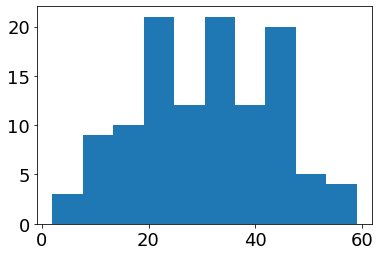

In [72]:
plt.hist(test.time_to_work)

In [85]:
test

,address,suburb,price,property_type,bedrooms,bathrooms,study,parking,time_to_work
0,129 Harrington St,Sydney,850.0,Apartment,1,1,False,1,8
1,37 Ivy Street,Darlington,850.0,Other,3,1,False,0,22
2,19/24 Campbell Street,Parramatta,540.0,Apartment,2,1,False,1,47
3,502/49-53 Regent Street,Chippendale,750.0,Apartment,2,2,False,1,23
4,2304/140 Church Street,Parramatta,630.0,Apartment,2,2,False,1,41
...,...,...,...,...,...,...,...,...,...
162,18/177 Glenayr Avenue,Bondi Beach,700.0,Unit,1,1,False,0,36
163,10 Paul Street,Bondi Junction,1400.0,Terrace,3,4,True,0,24
165,3/134 Ramsgate Avenue,North Bondi,2350.0,House,2,2,False,2,47
167,5/46 Sir Thomas Mitchell Road,Bondi Beach,720.0,Unit,2,1,False,0,40


In [87]:
import statsmodels.formula.api as smf

lm = smf.ols('price ~ time_to_work + C(bedrooms) + C(bathrooms) + C(property_type) + C(parking) + study', data=test).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     9.218
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           7.51e-14
Time:                        21:21:33   Log-Likelihood:                -854.27
No. Observations:                 117   AIC:                             1745.
Df Residuals:                      99   BIC:                             1794.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  723.8890    108.073      6.698      0.000     509.449     938.329
C(bedrooms)[T.2]                           142.8527    101.054      1.414      0.161     -57.660     343.366
C(bedrooms)[T.3]                           338.7998    158.789      2.134      0.035      23.727     653.872
C(bedrooms)[T.4]                           612.7642    263.202      2.328      0.022      90.515    1135.014
C(bathrooms)[T.2]                          266.6652    109.161      2.443      0.016      50.067     483.264
C(bathrooms)[T.3]                          734.6941    247.711      2.966      0.004     243.181    1226.207
C(bathrooms)[T.4]                          179.1640    229.650      0.780      0.437    -276.512     634.840
C(property_type)[T.Duplex/Semi-detached]   -14.6679    401.550     -0.037      0.971    -811.431     782.095
C(property_type)[T.House]                   -7.3007    150.314     -0.049      0.961    -305.557     290.956
C(property_type)[T.Other]                  -73.7631    420.187     -0.176      0.861    -907.506     759.980
C(property_type)[T.Studio]                -196.5983    239.182     -0.822      0.413    -671.186     277.990
C(property_type)[T.Terrace]                179.1640    229.650      0.780      0.437    -276.512     634.840
C(property_type)[T.Townhouse]             -520.2444    243.783     -2.134      0.035   -1003.963     -36.526
C(property_type)[T.Unit]                   -36.7529    114.320     -0.321      0.749    -263.589     190.083
C(parking)[T.1]                            161.9788     96.070      1.686      0.095     -28.646     352.603
C(parking)[T.2]                            494.7443    166.233      2.976      0.004     164.902     824.587
C(parking)[T.3]                           1682.2309    482.638      3.485      0.001     724.572    2639.890
study[T.True]                              130.5386    184.550      0.707      0.481    -235.649     496.726
time_to_work                                -6.3148      3.408     -1.853      0.067     -13.078       0.448
==============================================================================
Omnibus:                       48.723   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.168
Skew:                           1.479   Prob(JB):                     1.66e-35
Kurtosis:                       7.910   Cond. No.                     2.37e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.34e-32. This might indicate that there are
strong multicollinearity problems o

C:\Users\camch\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time_to_work', ylabel='price'>

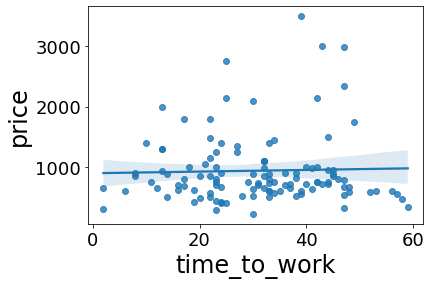

In [78]:
sns.regplot(test.time_to_work, test.price)